## Tumor vs Healthy classifier


In [1]:
from fastai.vision.all import *

In [2]:
torch.cuda.set_device(2)

In [3]:
file_path = Path('/mnt/tmabraham/data/qobmtohe/final/classifier')

In [4]:
file_path.ls()

(#5) [Path('/mnt/tmabraham/data/qobmtohe/final/classifier/H&E images'),Path('/mnt/tmabraham/data/qobmtohe/final/classifier/valid'),Path('/mnt/tmabraham/data/qobmtohe/final/classifier/train'),Path('/mnt/tmabraham/data/qobmtohe/final/classifier/models'),Path('/mnt/tmabraham/data/qobmtohe/final/classifier/test_combined')]

In [5]:
from sklearn.model_selection import KFold

In [6]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
train_imgs = get_image_files(file_path/'train')
tst_imgs = get_image_files(file_path/'valid')

In [8]:
_, val_idx = next(iter(kf.split(np.array(train_imgs+tst_imgs))))

In [9]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=partial(get_image_files,folders=['train','valid']),
                   splitter=IndexSplitter(val_idx),
                   get_y=parent_label)

dls = dblock.dataloaders(file_path, bs=128)

In [10]:
dls = ImageDataLoaders.from_folder(file_path, bs=128)

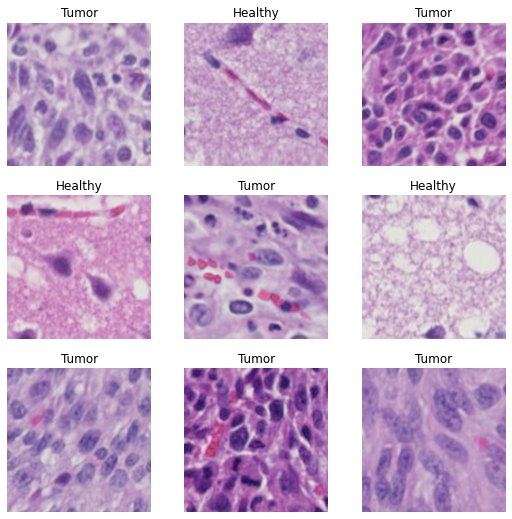

In [11]:
dls.show_batch()

In [12]:
learn = vision_learner(dls,resnet18,metrics=error_rate)

SuggestedLRs(valley=0.0012022644514217973)

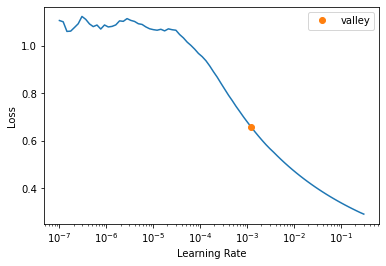

In [13]:
learn.lr_find()

In [14]:
learn.fine_tune(3,1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.204068,0.046890,0.014583,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.020581,5.712451,0.491667,00:05
1,0.009922,5.356066,0.450000,00:05
2,0.006487,0.003211,0.002083,00:05


In [15]:
interp = ClassificationInterpretation.from_learner(learn)

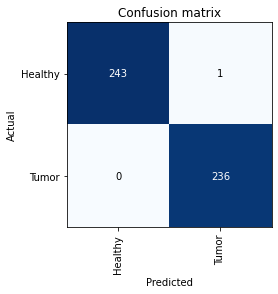

In [16]:
interp.plot_confusion_matrix()

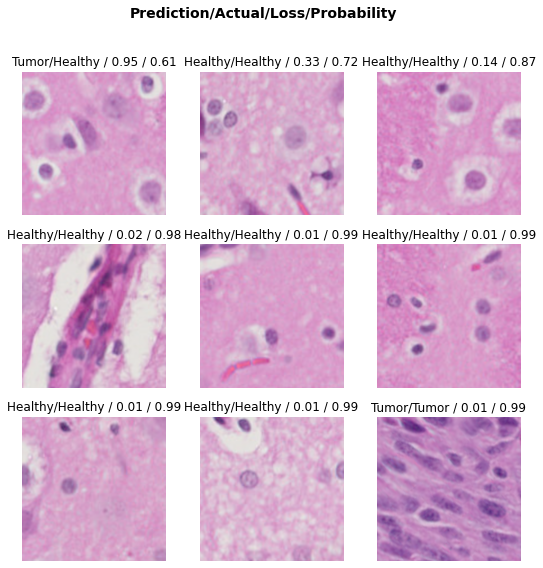

In [17]:
interp.plot_top_losses(k=10)

In [18]:
test_dl = dls.test_dl(get_image_files(file_path/'test_combined', folders=['Tumor','Healthy']), with_labels=True)

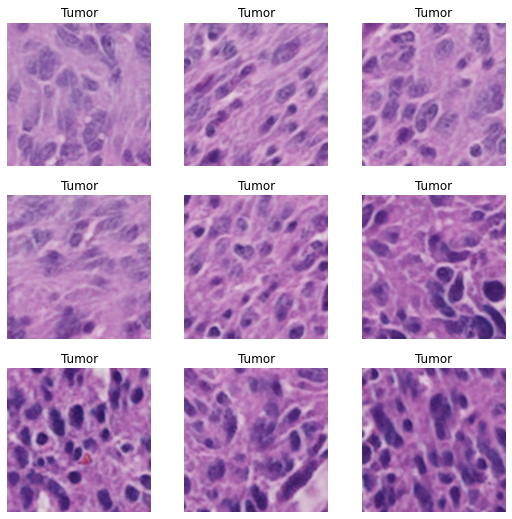

In [19]:
test_dl.show_batch()

In [20]:
learn.validate(dl=test_dl)

(#2) [0.7948107123374939,0.08518518507480621]

In [21]:
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)

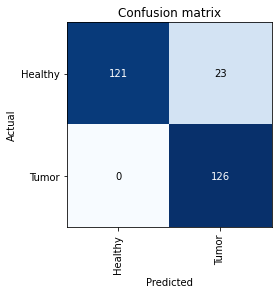

In [22]:
interp.plot_confusion_matrix()

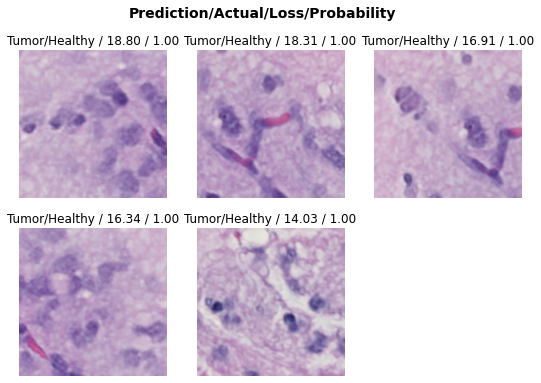

In [23]:
interp.plot_top_losses(k=5)

In [24]:
learn.path = Path('.')
learn.export('he_classifier.pkl')
learn.save('he_classifier')

Path('models/he_classifier.pth')

epoch,train_loss,valid_loss,error_rate,time
0,0.261826,0.010242,0.002865,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.011928,0.078387,0.017192,00:05
1,0.025350,1.843697,0.194842,00:04
2,0.023479,0.060795,0.020057,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.212519,0.001071,0.000000,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.015357,0.491918,0.065903,00:05
1,0.019034,0.687870,0.088825,00:05
2,0.015330,0.000110,0.000000,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.167232,0.015662,0.011461,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.006800,0.404223,0.103152,00:05
1,0.003433,0.000827,0.000000,00:05
2,0.002776,0.000040,0.000000,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.190483,0.006804,0.002865,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.019256,0.389818,0.108883,00:05
1,0.036624,0.074756,0.014327,00:05
2,0.025674,0.000257,0.000000,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.121438,0.009306,0.002874,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.008740,0.578246,0.117816,00:05
1,0.026693,1.053942,0.140805,00:05
2,0.017624,0.045527,0.011494,00:05


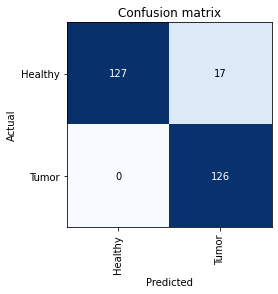

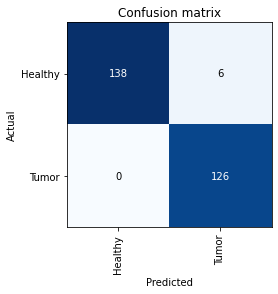

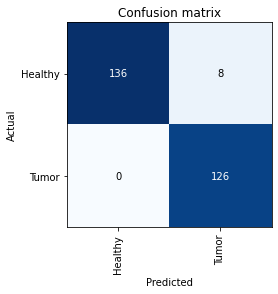

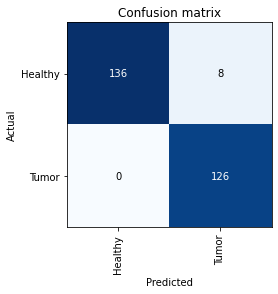

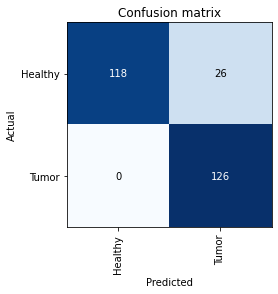

In [25]:
base_losses, base_error_rates = [], []
losses, error_rates, confusion_matrices = [], [], []
k=0
for _, val_idx in kf.split(np.array(train_imgs+tst_imgs)):

    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=partial(get_image_files,folders=['train','valid']),
                       splitter=IndexSplitter(val_idx),
                       get_y=parent_label)
    
    dls = dblock.dataloaders(file_path, bs=128)

    learn = vision_learner(dls,resnet18,metrics=error_rate)

    learn.fine_tune(3,1e-2)
    learn.path = Path('.')
    learn.export(f'he_classifier_fold{k}.pkl')
    learn.save(f'he_classifier_fold{k}.pkl')
    
    base_losses.append(learn.recorder.loss.value)
    base_error_rates.append(learn.recorder.metrics[0].value)
    
    test_dl = dls.test_dl(get_image_files(file_path/'test_combined', folders=['Tumor','Healthy']), with_labels=True)

    loss_val, error_rate_val = learn.validate(dl=test_dl)
    losses.append(loss_val)
    error_rates.append(error_rate_val)
    
    interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
    interp.plot_confusion_matrix()
    confusion_matrices.append(interp.confusion_matrix())
    k += 1

In [26]:
len(dls[0].dataset)

1396

In [27]:
len(dls[1].dataset)

348

In [28]:
np.mean(base_losses)

0.021345634

In [29]:
base_acc = 1-np.mean(base_error_rates)
print(base_acc*100)

99.36896874569356


In [30]:
base_std = np.std(1-np.array(base_error_rates))
print(base_std*100)

0.8189186453819275


In [31]:
base_acc * len(learn.dls[1].dataset)

345.8040112350136

In [32]:
acc = 1-np.mean(error_rates)
print(acc*100)

95.18518529832363


In [33]:
std = np.std(1-np.array(error_rates))
print(std*100)

2.7913250640203433


In [34]:
acc * len(test_dl.dataset)

257.0000003054738

In [41]:
confusion_matrices

[array([[127,  17],
        [  0, 126]]),
 array([[138,   6],
        [  0, 126]]),
 array([[136,   8],
        [  0, 126]]),
 array([[136,   8],
        [  0, 126]]),
 array([[118,  26],
        [  0, 126]])]

In [40]:
np.mean(confusion_matrices,axis=0)

array([[131.,  13.],
       [  0., 126.]])

In [42]:
np.std(confusion_matrices, axis=0)

array([[7.53657747, 7.53657747],
       [0.        , 0.        ]])